In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.extmath import safe_sparse_dot

from matchers import metrics
from matchers import utils
from matchers import dataset

In [3]:
np.set_printoptions(suppress=True)
tqdm.pandas()

### Load and process data

In [4]:
input_names, weighted_relevant_names, all_candidates = dataset.load_preprocess()

### Model

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char_wb', min_df=10, max_df=0.5)

In [9]:
X = vectorizer.fit_transform(all_candidates)

#### Similarity Function

In [10]:
def get_similars(name, k=10, demo_mode=False):
    if demo_mode:
        name = utils.add_padding(name)
    x = vectorizer.transform([name]).toarray()
    scores = safe_sparse_dot(X, x.T).flatten()
    sorted_scores_idx = np.argsort(scores)[::-1][:k]
    candidates = all_candidates[sorted_scores_idx]
    if demo_mode:
        candidates = [utils.remove_padding(candidate) for candidate in candidates]
    candidates_scores = scores[sorted_scores_idx]
    
    return list(zip(candidates, candidates_scores))

#### Demo

In [11]:
get_similars('schumacher', 10, True)

[('schumacker', 0.8092917375133881),
 ('schuman', 0.7500946651703772),
 ('schumann', 0.7027601314426227),
 ('schumaker', 0.6902077476321082),
 ('schacher', 0.6547967092097396),
 ('schum', 0.6372697150535584),
 ('scheuman', 0.5581147793510491),
 ('hamacher', 0.5418542569428891),
 ('amacher', 0.5358002092434181),
 ('stelmacher', 0.5294070446892177)]

### Generate candidates for all names

In [12]:
k = 100 # Number of candidates to consider
name_candidates = list(map(lambda x: get_similars(x, k=k), tqdm(input_names)))

100%|██████████| 23587/23587 [00:56<00:00, 414.11it/s]


In [13]:
len(name_candidates)

23587

In [14]:
candidates = np.array(name_candidates, dtype=[('name','O'),('score', 'f8')])

### Evaluation

### mAP@0.8

In [15]:
metrics.avg_precision_at_threshold(weighted_relevant_names, candidates, 0.8)

0.7263534998092169

### mAP@0.5

In [16]:
metrics.avg_precision_at_threshold(weighted_relevant_names, candidates, 0.5)

0.20709488267797801

### Precision-Recall Curve

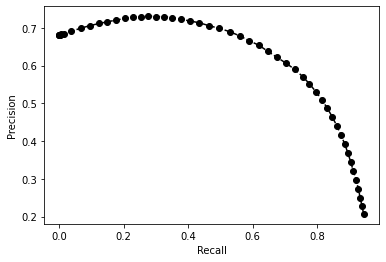

In [17]:
# minimum score threshold to test
min_threshold = 0.5
metrics.precision_recall_curve_at_threshold(weighted_relevant_names, candidates, min_threshold)

### Test

In [21]:
weighted_relevant_names[8]

[('<aarons>', 0.4110330823250698), ('<aron>', 0.5889669176749301)]

In [23]:
candidates[8][:5]

array([('<aaronson>', 0.82690353), ('<aarons>', 0.80859468),
       ('<aron>', 0.7480946 ), ('<charon>', 0.54476603),
       ('<aarnes>', 0.47702161)], dtype=[('name', 'O'), ('score', '<f8')])

In [30]:
metrics.recall_at_threshold(weighted_relevant_names[8], candidates[8], 0.77)

0.4110330823250698

In [31]:
metrics.recall_at_threshold(weighted_relevant_names[8], candidates[8], 0.71)

1.0